# Sentiment Analysis Bag-of-Words
## Movie Reviews (smaller Data-Set)

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn 
import nltk
import re
import csv
from evaluation import test_statistics


## 1. Data Loading

In [3]:
train_set = pd.read_csv ("../data/dataset_mr/Trainset_complete.csv", sep = ';')
test_set = pd.read_csv ("../data/dataset_mr/Testset.csv", sep = ';')

# so Daten laden, wenn das test_set Sentiment Labels hätte:
#train_set = pd.read_csv ("train.tsv", sep = '\t')
#test_set= pd.read_csv ("test.tsv", sep = '\t')
#pd.set_option('display.max_colwidth', None)
#test_set.head(10)

In [4]:
train_set.Sentiment.value_counts()

# Daten ausbalancieren im Trainings-Set? 
# Jeder Sentiment Value sollte gleiche Anzahl an Samples haben 

-1    2696
 0    2696
 1    2696
Name: Sentiment, dtype: int64

## 2. Data cleaning

In [5]:
import nltk
# nltk.download('stopwords')
# pip install nltk
import re


# Für Sentimentanalyse zählen nur Wörter  
def keep_only_letters(text):
    text=re.sub(r'[^a-zA-Z\s]','',text)
    return text
 
# Groß- und Kleinschreibung egal 
def convert_to_lowercase(text):
    return text.lower()
 
def clean_reviews(text):
    text = keep_only_letters(text)
    text = convert_to_lowercase(text)
    return text


# Stop Words definition
english_stop_words = nltk.corpus.stopwords.words('english')
print(len(english_stop_words))
print (english_stop_words[:20])

# Stop Words removal
def remove_stop_words(text):
    for stopword in english_stop_words:
        stopword = ' ' + stopword + ' '
        text = text.replace(stopword, ' ')
    return text


# Stemming
def text_stemming(text):
    stemmer = nltk.porter.PorterStemmer()
    stemmed = ' '.join([stemmer.stem(token) for token in text.split()])
    return stemmed




train_set['Phrase'] = train_set['Phrase'].apply(clean_reviews)
# test_set['Phrase'] = test_set['Phrase'].apply(clean_reviews)

train_set['Phrase'] = train_set['Phrase'].apply(remove_stop_words)
# test_set['Phrase'] = test_set['Phrase'].apply(remove_stop_words)

train_set['Phrase'] = train_set['Phrase'].apply(text_stemming) 
#test_set['Phrase'] = test_set['Phrase'].apply(text_stemming)

#train_set.head(10)
#train_set.shape
#test_set.shape

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


## 3. Text Vectorization
CountVectorizer aus sklearn um bag-of-words Darstellung von unserem Trainings- und Testset zu erhalten
naive bag-of-words text vectorization

Nur Trainingsdatensatz zur Definition des Vokabulars heranziehen und 
das gleiche Vokabular zur Darstellung des Test-Datensatzes verwenden
-> Vektorizer an Trainingsdaten anpassen und zur Transformation der Testdaten verwenden

weighted version of BOW ausprobieren?

### N-Grams

Unigramme: Alle eindeutigen Wörter in einem Dokument

BiGramme: Alle Permutationen von zwei aufeinanderfolgenden Wörtern in einem Dokument

TriGrams: Alle Permutationen von drei aufeinanderfolgenden Wörtern in einem Dokument

In [6]:
import sklearn
# convert text data to numeric

# Argument binary=False: Vocabel-Vector mit term-frequency füllen
# binary = True: Vocabel-Vector mit Vorhandensein der Token füllen (1 vorhanden, 0 nicht vorhanden) 
# ngram _range = Unigram: (1,1); Bigram: (1,2); Trigram: (1,3)

vectorizer_uni = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,1))
vectorizer_bi = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,2))
vectorizer_tri = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,3))

In [7]:
uni_features_train = vectorizer_uni.fit_transform(train_set['Phrase'])
uni_features_test = vectorizer_uni.transform(test_set['Phrase'])
#print (uni_features_train.shape, uni_features_test.shape)

bi_features_train = vectorizer_bi.fit_transform(train_set['Phrase'])
bi_features_test = vectorizer_bi.transform(test_set['Phrase'])
#print (bi_features_train.shape, bi_features_test.shape)

tri_features_train = vectorizer_tri.fit_transform(train_set['Phrase'])
tri_features_test = vectorizer_tri.transform(test_set['Phrase'])
#print (tri_features_train.shape, tri_features_test.shape)

Unigram:
(156060, 10998) (66292, 10998): 10998 einzigartige englische token in unserem Vokabular (abgeleitet aus Trainingsdatensatz)
Jeder Token wird durch eine Spalte im Datensatz repräsentiert
Für jedes Review im Datensatz wird die Frequency der Token (term-frequency) durch Vokabel-Vector der Größe 10998 dargestellt.
= Daher haben wir 156060 solcher Vektoren in unserem Trainings-Datensatz und 66292 in unserem Test-Datensatz = Anzahl der Reviews 

In [8]:
train_labels = train_set['Sentiment']
test_labels = test_set['Sentiment']

## 4. Klassifizierungsmodelle trainieren
### 4.1.  Naive Bayes
#### 4.1.1. Unigram (Logistic Regression classifier on unigram features)

In [9]:
from sklearn.naive_bayes import MultinomialNB
 
vectorizer_uni = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,1))
uni_features_train = vectorizer_uni.fit_transform(train_set['Phrase'])
uni_features_test = vectorizer_uni.transform(test_set['Phrase'])

uni_nb = MultinomialNB()
uni_nb.fit(uni_features_train, train_labels)
 
predictions = uni_nb.predict(uni_features_test)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['-1','0','1']))


              precision    recall  f1-score   support

          -1       0.44      0.36      0.40       459
           0       0.34      0.53      0.41       459
           1       0.58      0.35      0.44       459

    accuracy                           0.42      1377
   macro avg       0.45      0.42      0.42      1377
weighted avg       0.45      0.42      0.42      1377

[[167 249  43]
 [143 243  73]
 [ 70 227 162]]


[Text(0, 0.5, '-1'), Text(0, 1.5, '0'), Text(0, 2.5, '1')]

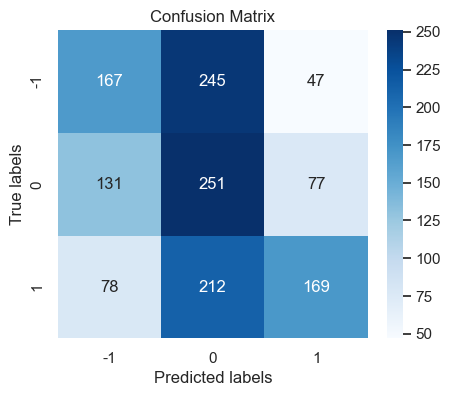

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt  

co_ma = sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[-1, 0, 1])   

ax= plt.subplot()
sns.heatmap(co_ma, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues);  #annot=True to annotate cells, ftm='g' to disable scientific notation
sns.set (rc = {'figure.figsize':(5, 4)})
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['-1', '0','1']); ax.yaxis.set_ticklabels(['-1', '0','1'])

#### 4.1.2 Naive Bayes: Unigram + Bigram

In [10]:
#vectorizer_bi = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,2))
#bi_features_train = vectorizer_bi.fit_transform(train_set['Phrase'])
#bi_features_test = vectorizer_bi.transform(test_set['Phrase'])

bi_nb = MultinomialNB()
bi_nb.fit(bi_features_train, train_labels)
 
predictions = bi_nb.predict(bi_features_test)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['-1','0','1']))


              precision    recall  f1-score   support

          -1       0.44      0.38      0.41       459
           0       0.34      0.49      0.40       459
           1       0.57      0.39      0.47       459

    accuracy                           0.42      1377
   macro avg       0.45      0.42      0.43      1377
weighted avg       0.45      0.42      0.43      1377

[[175 237  47]
 [144 225  90]
 [ 77 201 181]]


[Text(0, 0.5, '-1'), Text(0, 1.5, '0'), Text(0, 2.5, '1')]

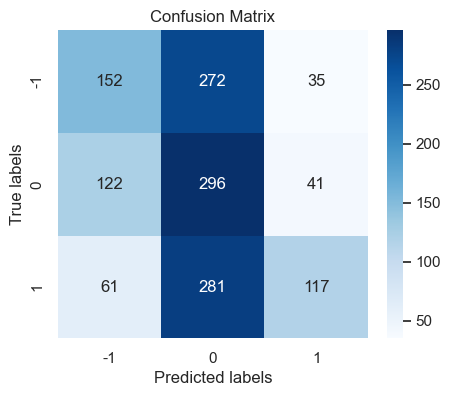

In [81]:
co_ma = sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[-1, 0, 1])   

ax= plt.subplot()
sns.heatmap(co_ma, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['-1', '0','1']); ax.yaxis.set_ticklabels(['-1', '0','1'])

#### 4.1.3 Naive Bayes: Unigram + Bigram + Trigram

In [11]:
tri_nb = MultinomialNB()
tri_nb.fit(tri_features_train, train_labels)
 
predictions = tri_nb.predict(tri_features_test)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['-1','0','1']))


              precision    recall  f1-score   support

          -1       0.44      0.39      0.41       459
           0       0.34      0.48      0.40       459
           1       0.57      0.41      0.47       459

    accuracy                           0.43      1377
   macro avg       0.45      0.43      0.43      1377
weighted avg       0.45      0.43      0.43      1377

[[178 228  53]
 [147 222  90]
 [ 77 195 187]]


In [ ]:
co_ma = sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[-1, 0, 1])   

ax= plt.subplot()
sns.heatmap(co_ma, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['-1', '0','1']); ax.yaxis.set_ticklabels(['-1', '0','1'])

### 4.2 Logistische Regression
#### 4.2.1. Unigram

In [12]:
uni_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
uni_logreg.fit(uni_features_train, train_labels)
#print (uni_logreg)

""" default state of the classifier: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)"""

# Predictions für unseren Test-Datensatz, Accuracy, Confusion-Matrix berechnen: 

predictions = uni_logreg.predict(uni_features_test)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['-1','0','1']))


              precision    recall  f1-score   support

          -1       0.47      0.32      0.38       459
           0       0.35      0.66      0.46       459
           1       0.61      0.25      0.36       459

    accuracy                           0.41      1377
   macro avg       0.48      0.41      0.40      1377
weighted avg       0.48      0.41      0.40      1377

[[146 281  32]
 [114 304  41]
 [ 53 291 115]]


In [ ]:
co_ma = sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[-1, 0, 1])   

ax= plt.subplot()
sns.heatmap(co_ma, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['-1', '0','1']); ax.yaxis.set_ticklabels(['-1', '0','1'])

[Text(0, 0.5, '-1'), Text(0, 1.5, '0'), Text(0, 2.5, '1')]

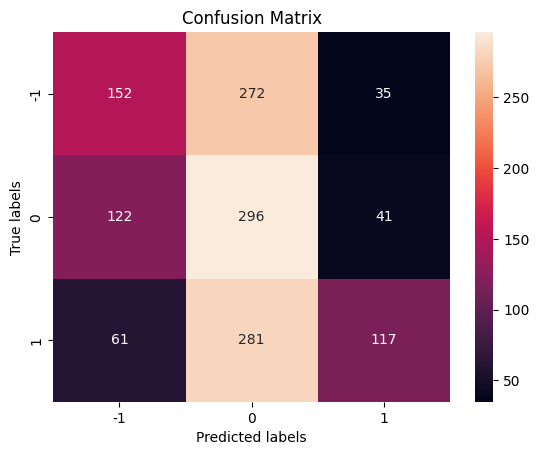

In [60]:
co_ma = sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[-1, 0, 1])   

ax= plt.subplot()
sns.heatmap(co_ma, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['-1', '0','1']); ax.yaxis.set_ticklabels(['-1', '0','1'])

#### 4.2.2. Log Regression: Unigrams + Bigrams

In [13]:
bi_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
bi_logreg.fit(bi_features_train, train_labels)
#print (bi_logreg)

predictions = bi_logreg.predict(bi_features_test)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['-1','0','1']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[-1, 0, 1]))
# Feature-Set Größe erhöht sich weil auch Bi-Gramme berücksichtigt 

              precision    recall  f1-score   support

          -1       0.47      0.38      0.42       459
           0       0.37      0.61      0.46       459
           1       0.59      0.31      0.41       459

    accuracy                           0.43      1377
   macro avg       0.47      0.43      0.43      1377
weighted avg       0.47      0.43      0.43      1377

[[175 233  51]
 [129 281  49]
 [ 69 248 142]]


#### 4.2.3. Log Regression: Unigrams + Bigrams + Trigrams

In [14]:
tri_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
tri_logreg.fit(tri_features_train, train_labels)
#print (tri_logreg)

predictions = tri_logreg.predict(tri_features_test)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['-1','0','1']))

              precision    recall  f1-score   support

          -1       0.46      0.40      0.43       459
           0       0.36      0.57      0.44       459
           1       0.55      0.31      0.39       459

    accuracy                           0.42      1377
   macro avg       0.46      0.42      0.42      1377
weighted avg       0.46      0.42      0.42      1377

[[182 221  56]
 [139 261  59]
 [ 71 247 141]]


In [ ]:
co_ma = sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[-1, 0, 1])   

ax= plt.subplot()
sns.heatmap(co_ma, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['-1', '0','1']); ax.yaxis.set_ticklabels(['-1', '0','1'])

### 4.3 Linear Support Vector Machine (LSVM) 
#### 4.3.1. Unigram 

In [15]:
uni_lsvm = sklearn.svm.LinearSVC()
uni_lsvm.fit(uni_features_train, train_labels)
 
predictions = uni_lsvm.predict(uni_features_test)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['-1','0','1']))

              precision    recall  f1-score   support

          -1       0.47      0.35      0.40       459
           0       0.36      0.64      0.46       459
           1       0.54      0.27      0.36       459

    accuracy                           0.42      1377
   macro avg       0.46      0.42      0.41      1377
weighted avg       0.46      0.42      0.41      1377

[[160 255  44]
 [107 293  59]
 [ 72 264 123]]


In [ ]:
co_ma = sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[-1, 0, 1])   

ax= plt.subplot()
sns.heatmap(co_ma, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['-1', '0','1']); ax.yaxis.set_ticklabels(['-1', '0','1'])

#### 4.3.2. LSVM: Unigram + Bigram 

In [16]:
bi_lsvm = sklearn.svm.LinearSVC()
bi_lsvm.fit(bi_features_train, train_labels)
 
predictions = bi_lsvm.predict(bi_features_test)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['-1','0','1']))

              precision    recall  f1-score   support

          -1       0.44      0.38      0.41       459
           0       0.36      0.58      0.45       459
           1       0.56      0.30      0.39       459

    accuracy                           0.42      1377
   macro avg       0.45      0.42      0.41      1377
weighted avg       0.45      0.42      0.41      1377

[[174 228  57]
 [142 266  51]
 [ 80 241 138]]


In [ ]:
co_ma = sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[-1, 0, 1])   

ax= plt.subplot()
sns.heatmap(co_ma, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['-1', '0','1']); ax.yaxis.set_ticklabels(['-1', '0','1'])

#### 4.3.3. LSVM: Unigram + Bigram + Trigram

In [17]:
tri_lsvm = sklearn.svm.LinearSVC()
tri_lsvm.fit(tri_features_train, train_labels)
 
predictions = tri_lsvm.predict(tri_features_test)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['-1','0','1']))

              precision    recall  f1-score   support

          -1       0.46      0.38      0.42       459
           0       0.36      0.62      0.46       459
           1       0.55      0.26      0.35       459

    accuracy                           0.42      1377
   macro avg       0.46      0.42      0.41      1377
weighted avg       0.46      0.42      0.41      1377

[[176 237  46]
 [125 285  49]
 [ 82 259 118]]


In [ ]:
co_ma = sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[-1, 0, 1])   

ax= plt.subplot()
sns.heatmap(co_ma, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['-1', '0','1']); ax.yaxis.set_ticklabels(['-1', '0','1'])

Vergleich: TFIDF-Features

In [ ]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(use_idf=True,ngram_range=(1,1))
tfidf_features_train = vectorizer.fit_transform(train_set['Phrase'])
tfidf_features_test = vectorizer.transform(test_set['Phrase'])
print (tfidf_features_train.shape, tfidf_features_test.shape)


In [ ]:
#train model
clf = sklearn.linear_model.LogisticRegression()
clf.fit(tfidf_features_train, train_labels)
 
#evaluation
predictions = clf.predict(tfidf_features_test)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['-1','0','1']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels = [-1, 0, 1]))

# Sentiment Analysis Bag-of-Words
## Tweets (Larger Data-Set)

In [2]:
import csv
with open("../data/tweets.csv") as csvdatei:
    data = pd.read_csv(csvdatei, delimiter=',')

data.columns = ['Sentiment','ID','date','flag','user','Phrase']
data.drop(['date','flag','user'], axis=1, inplace=True)
data = sklearn.utils.shuffle(data)

data.Sentiment.value_counts()

4    800000
0    799999
Name: Sentiment, dtype: int64

In [3]:
import nltk
# nltk.download('stopwords')
# pip install nltk
import re

# Zeitbedarf: 7m 14s


# Für Sentimentanalyse zählen nur Wörter  
def keep_only_letters(text):
    text=re.sub(r'[^a-zA-Z\s]','',text)
    return text
 
# Groß- und Kleinschreibung egal 
def convert_to_lowercase(text):
    return text.lower()
 
def clean_reviews(text):
    text = keep_only_letters(text)
    text = convert_to_lowercase(text)
    return text


# Stop Words definition
english_stop_words = nltk.corpus.stopwords.words('english')
#print(len(english_stop_words))
#print (english_stop_words[:20])

# Stop Words removal
def remove_stop_words(text):
    for stopword in english_stop_words:
        stopword = ' ' + stopword + ' '
        text = text.replace(stopword, ' ')
    return text


# Stemming
def text_stemming(text):
    stemmer = nltk.porter.PorterStemmer()
    stemmed = ' '.join([stemmer.stem(token) for token in text.split()])
    return stemmed




#data['Phrase'] = data['Phrase'].apply(clean_reviews)
# test_set['Phrase'] = test_set['Phrase'].apply(clean_reviews)

#data['Phrase'] = data['Phrase'].apply(remove_stop_words)
# test_set['Phrase'] = test_set['Phrase'].apply(remove_stop_words)

#data['Phrase'] = data['Phrase'].apply(text_stemming) 
#test_set['Phrase'] = test_set['Phrase'].apply(text_stemming)

In [5]:
# Train Test Split
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data, test_size=0.2)

In [6]:
train_set.Sentiment.value_counts()

4    640469
0    639530
Name: Sentiment, dtype: int64

## 3. Text Vectorization

In [7]:
import sklearn
# convert text data to numeric

# Argument binary=False: Vocabel-Vector mit term-frequency füllen
# binary = True: Vocabel-Vector mit Vorhandensein der Token füllen (1 vorhanden, 0 nicht vorhanden) 
# ngram _range = Unigram: (1,1); Bigram: (1,2); Trigram: (1,3)

vectorizer_uni = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,1))
vectorizer_bi = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,2))
vectorizer_tri = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,3))


In [8]:
# Dauer mit Cleaning: 3m 24s 
# Dauer ohne Cleaning: 4m 46s 

uni_features_train = vectorizer_uni.fit_transform(train_set['Phrase'])
uni_features_test = vectorizer_uni.transform(test_set['Phrase'])
#print (uni_features_train.shape, uni_features_test.shape)

bi_features_train = vectorizer_bi.fit_transform(train_set['Phrase'])
bi_features_test = vectorizer_bi.transform(test_set['Phrase'])
#print (bi_features_train.shape, bi_features_test.shape)

tri_features_train = vectorizer_tri.fit_transform(train_set['Phrase'])
tri_features_test = vectorizer_tri.transform(test_set['Phrase'])
#print (tri_features_train.shape, tri_features_test.shape)

In [9]:
train_labels = train_set['Sentiment']
test_labels = test_set['Sentiment']

## Klassifizierungsmodelle trainieren

In [10]:
# Naive Bayes Unigram 
# mit Cleaning: Zeit: 2s Accuracy: 0.77
# ohne Cleaning: Zeit: 2s Accuracy: 0.78

from sklearn.naive_bayes import MultinomialNB

uni_nb = MultinomialNB()
uni_nb.fit(uni_features_train, train_labels)
 
predictions = uni_nb.predict(uni_features_test)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.76      0.82      0.79    160469
           4       0.80      0.74      0.77    159531

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000

[[131166  29303]
 [ 40827 118704]]


In [ ]:
co_ma = sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 1])   

ax= plt.subplot()
sns.heatmap(co_ma, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['0','1']); ax.yaxis.set_ticklabels(['0','1'])

In [11]:
# Naive Bayes Unigram + Bigram
# mit Cleaning: Zeit: 6.5s Accuracy: 0.78
# ohne Cleaning: Zeit: 6.5s Accuracy: 0.80

bi_nb = MultinomialNB()
bi_nb.fit(bi_features_train, train_labels)
 
predictions = bi_nb.predict(bi_features_test)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['0','4']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 4]))


              precision    recall  f1-score   support

           0       0.78      0.84      0.81    160469
           4       0.83      0.76      0.79    159531

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000

[[135485  24984]
 [ 38642 120889]]


In [12]:
# Naive Bayes Unigram + Bigram + Trigram
# mit Cleaning: Zeit: 4.2s Accuracy: 0.79
# mit Cleaning: Zeit: 4.2s Accuracy: 0.80

tri_nb = MultinomialNB()
tri_nb.fit(tri_features_train, train_labels)
 
predictions = tri_nb.predict(tri_features_test)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['0','4']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 4]))


              precision    recall  f1-score   support

           0       0.78      0.85      0.81    160469
           4       0.83      0.76      0.79    159531

    accuracy                           0.80    320000
   macro avg       0.81      0.80      0.80    320000
weighted avg       0.81      0.80      0.80    320000

[[136124  24345]
 [ 38513 121018]]


In [13]:
# Logistische Regression Unigram
# mit Cleaning: Zeit: 5m 50s Accuracy: 0.78
# ohne Cleaning: Zeit: 7m 26s Accuracy: 0.80


uni_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
uni_logreg.fit(uni_features_train, train_labels)

predictions = uni_logreg.predict(uni_features_test)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['0','4']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 4]))


              precision    recall  f1-score   support

           0       0.81      0.79      0.80    160469
           4       0.79      0.81      0.80    159531

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000

[[126367  34102]
 [ 30165 129366]]


In [29]:
# Logistische Regression Unigram + Bigram
# mit Cleaning: Zeit: 20m 7s Accuracy: 0.80 


bi_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
bi_logreg.fit(bi_features_train, train_labels)
#print (bi_logreg)

predictions = bi_logreg.predict(bi_features_test)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['0','4']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 4]))
# Feature-Set Größe erhöht sich weil auch Bi-Gramme berücksichtigt 

              precision    recall  f1-score   support

           0       0.81      0.78      0.80    159839
           4       0.79      0.82      0.80    160161

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000

[[124923  34916]
 [ 29087 131074]]


In [30]:
# Logistische Regression Unigram + Bigram + Trigram
# mit Cleaning: Zeit: 36m 21s Accuracy: 0.80 

tri_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
tri_logreg.fit(tri_features_train, train_labels)
#print (tri_logreg)

predictions = tri_logreg.predict(tri_features_test)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['0','4']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 4]))

              precision    recall  f1-score   support

           0       0.81      0.78      0.80    159839
           4       0.79      0.82      0.81    160161

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000

[[125228  34611]
 [ 28664 131497]]


In [31]:
# Linear Support Vector Machine (LSVM) Unigram
# mit Cleaning: Zeit: 10m 12s Accuracy: 0.77 

uni_lsvm = sklearn.svm.LinearSVC(max_iter=10000)
uni_lsvm.fit(uni_features_train, train_labels)
 
predictions = uni_lsvm.predict(uni_features_test)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['0','4']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 4]))

C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.77      0.77      0.77    159839
           4       0.77      0.77      0.77    160161

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000

[[122554  37285]
 [ 36412 123749]]


In [32]:
# Linear Support Vector Machine (LSVM) Unigram + Bigram
# mit Cleaning: Zeit: 11m 30s Accuracy: 0.79 

bi_lsvm = sklearn.svm.LinearSVC(max_iter=10000)
bi_lsvm.fit(bi_features_train, train_labels)
 
predictions = bi_lsvm.predict(bi_features_test)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['0','4']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 4]))

C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.79      0.78      0.78    159839
           4       0.78      0.79      0.79    160161

    accuracy                           0.79    320000
   macro avg       0.79      0.78      0.78    320000
weighted avg       0.79      0.79      0.78    320000

[[123915  35924]
 [ 32874 127287]]


In [33]:
# Linear Support Vector Machine (LSVM) Unigram + Bigram + Trigram
# mit Cleaning: Zeit: 13m 10s Accuracy: 0.79

tri_lsvm = sklearn.svm.LinearSVC(max_iter=10000)
tri_lsvm.fit(tri_features_train, train_labels)
 
predictions = tri_lsvm.predict(tri_features_test)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['0','4']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 4]))

C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.80      0.78      0.79    159839
           4       0.79      0.80      0.80    160161

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000

[[124800  35039]
 [ 31339 128822]]
